In [5]:
import numpy as np
import pandas as pd

import seaborn as sbn

import matplotlib.pyplot as plt
from matplotlib import rcParams  
rcParams['figure.figsize'] = (15, 15) #Size of figure  
rcParams['figure.dpi'] = 125

% matplotlib inline

## plotting spatial stuff

In [2]:
pos = pd.read_csv('inferred_locations.csv')

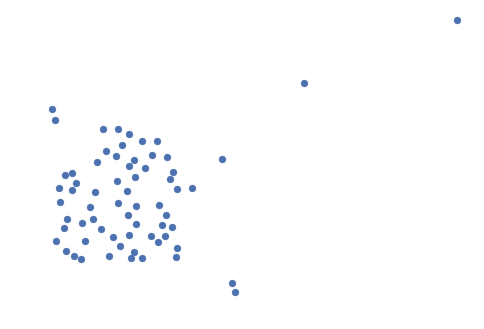

In [15]:
sbn.set(style="white")
plt.scatter(pos['x'],pos['y'])
sbn.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.axis('off')
plt.savefig('locations.png', transparent=True)

## plotting mpc

In [16]:
import scipy.io as sio

In [17]:
mpcperfect = sio.loadmat('mpcperfect.mat')

In [18]:
mpcperfect

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun  7 19:03:48 2017',
 '__version__': '1.0',
 'custWaiting': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'numVehiclesRebalancing': array([[ 0],
        [ 0],
        [ 0],
        ..., 
        [52],
        [52],
        [ 0]], dtype=uint16),
 'numVehiclesServing': array([[  0],
        [  0],
        [  0],
        ..., 
        [642],
        [643],
        [  0]], dtype=uint16)}

In [38]:
mpcperfect['numVehiclesRebalancing'][:,0].shape

(14400,)

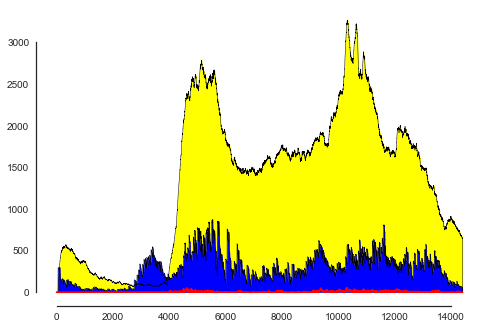

In [35]:
sbn.set(style="white")
plt.fill_between(range(14400),mpcperfect['numVehiclesServing'][:,0], color='yellow')
plt.plot(range(14400),mpcperfect['numVehiclesServing'][:,0], color='black', linewidth=0.5)
plt.fill_between(range(14400),mpcperfect['numVehiclesRebalancing'][:,0], color='blue')
plt.plot(range(14400),mpcperfect['numVehiclesRebalancing'][:,0], color='black', linewidth=0.5)
plt.plot(range(14400),mpcperfect['custWaiting'].sum(axis=1), color='red')

sbn.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=True)
plt.title('MPC with Perfect Information')